## Load Data

In [1]:
%mkdir ./data

In [2]:
from zipfile import ZipFile
zf = ZipFile('./data.zip', 'r')
zf.extractall('./')
zf.close()

## Data Preprocessing

I first import necessary libraries and check how large a typical image is.

In [8]:
import cv2
import os
import glob
import pickle
import numpy as np
import pandas as pd

im = cv2.imread('./data/Train/0/00000_00000_00000.png') 
print(im.shape)

(30, 29, 3)


I define a function to ouput the numpy array (of images) for one class

In [9]:
# function to read and resize images, get labels and store them into np array
def get_image_label_resize(label, filelist, dim = (32, 32), dataset = 'Train'):
    x = np.array([cv2.resize(cv2.imread(fname), dim, interpolation = cv2.INTER_AREA) for fname in filelist])
    y = np.array([label] * len(filelist))
        
    #print('{} examples loaded for label {}'.format(x.shape[0], label))
    return (x, y)    

To avoid repeated processing, I saved the processed data into a pickle file. In case any interruption, I could load the data from pickle.

In [10]:
cache_dir = './cache'
if not os.path.exists(cache_dir): # Make sure that the folder exists
    os.makedirs(cache_dir)

def process_train_data():
    cache_file, cache_data = "train.pkl", None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  
    if not cache_data:
        # data for label 0. I store them in parent level so that they won't be uploaded to github
        filelist = glob.glob('./data/Train/'+'0'+'/*.png')
        trainx, trainy = get_image_label_resize(0, glob.glob('./data/Train/'+str(0)+'/*.png'))
        # go throgh all others labels and store images into np array
        for label in range(1, 43):
            filelist = glob.glob('./data/Train/'+str(label)+'/*.png')
            x, y = get_image_label_resize(label, filelist)
            trainx = np.concatenate((trainx ,x))
            trainy = np.concatenate((trainy ,y))
        if cache_file is not None:
            cache_data = {'trainx': trainx, 'trainy': trainy}
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        trainx, trainy = cache_data['trainx'], cache_data['trainy']
    return trainx, trainy

In [11]:
trainx, trainy = process_train_data()

Read preprocessed data from cache file: train.pkl


I did the same for testing data.

In [12]:
def process_test_data():
    cache_file, cache_data = 'test.pkl', None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  
    if not cache_data:
        # get path for test images
        testfile = pd.read_csv('./data/Test.csv')['Path'].apply(lambda x: './data/' + x).tolist()
        testx = np.array([cv2.resize(cv2.imread(fname), (32, 32), interpolation = cv2.INTER_AREA) for fname in testfile])
        testy = np.array(pd.read_csv('./data/Test.csv')['ClassId'])
        if cache_file is not None:
            cache_data = {'testx': testx, 'testy': testy}
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        testx, testy = cache_data['testx'], cache_data['testy']
    return testx, testy

In [13]:
X_test, y_test = process_test_data()
print(X_test.shape, y_test.shape)

Read preprocessed data from cache file: test.pkl
(12630, 32, 32, 3) (12630,)


Next, I show the distribution of classes.

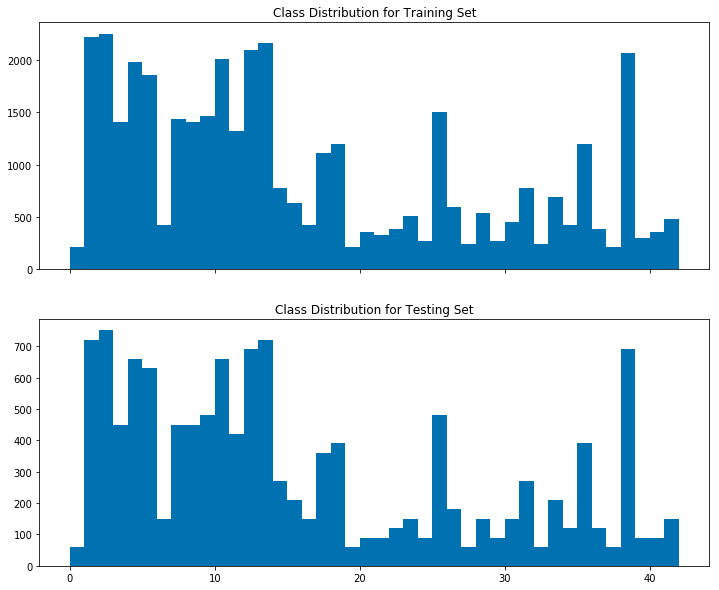

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

fig, ax = plt.subplots(2, 1, sharex = True, figsize = (12,10))
ax[0].set_title('Class Distribution for Training Set')
ax[0].hist(trainy, bins = len(np.unique(trainy))-1)

ax[1].set_title('Class Distribution for Testing Set')
ax[1].hist(y_test, bins = len(np.unique(y_test))-1)
plt.show()

In [16]:
# shuffle training data and split them into training and validation
indices = np.random.permutation(trainx.shape[0])
# 20% to val
split_idx = int(trainx.shape[0]*0.8)
train_idx, val_idx = indices[:split_idx], indices[split_idx:]
X_train, X_validation = trainx[train_idx,:], trainx[val_idx,:]
y_train, y_validation = trainy[train_idx], trainy[val_idx]

In [17]:
# get overall stat of the whole dataset
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("There are {} training examples ".format(n_train))
print("There are {} validation examples".format(n_validation))
print("There are {} testing examples".format(n_test))
print("Image data shape is {}".format(image_shape))
print("There are {} classes".format(n_classes))

There are 31367 training examples 
There are 7842 validation examples
There are 12630 testing examples
Image data shape is (32, 32, 3)
There are 43 classes


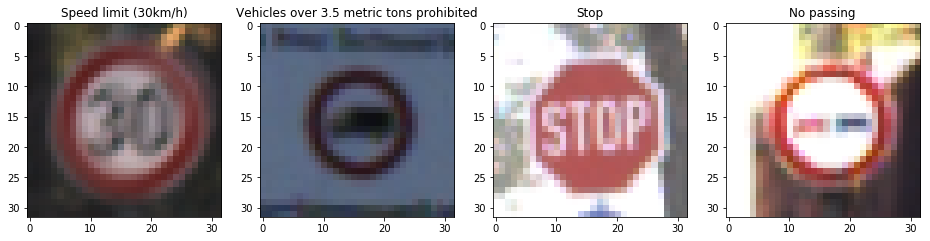

In [18]:
import random
# descriptions for each label
sign = pd.read_csv('data/signnames.csv')

idx = random.sample(range(n_train), 4)
fig, ax = plt.subplots(1, 4, figsize = (16, 64))
for i in range(4):
    ax[i].set_title(sign.loc[sign['ClassId'] ==y_train[idx[i]], 'SignName'].values[0])
    ax[i].imshow(cv2.cvtColor(X_train[idx[i]], cv2.COLOR_BGR2RGB))
plt.show()

I convert the images to grayscale and normaolize them.

In [19]:
# convert the images to grayscale
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)
X_validation_gry = np.sum(X_validation/3, axis=3, keepdims=True)
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

# Normalize data
X_train_normalized_gry = (X_train_gry-128)/128
X_validation_normalized_gry = (X_validation_gry-128)/128
X_test_normalized_gry = (X_test_gry-128)/128

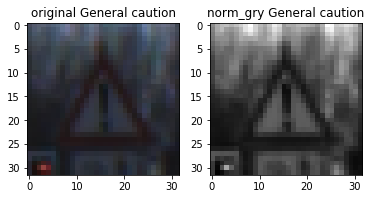

In [20]:
# pick an image, display the original and the normalized gray image
index = np.random.randint(0, n_train)
fig, ax = plt.subplots(1,2)
ax[0].set_title('original ' + sign.loc[sign['ClassId'] ==y_train[index], 'SignName'].values[0])
ax[0].imshow(cv2.cvtColor(X_train[index], cv2.COLOR_BGR2RGB))

ax[1].set_title('norm_gry ' + sign.loc[sign['ClassId'] ==y_train[index], 'SignName'].values[0])
ax[1].imshow(X_train_normalized_gry[index].squeeze(), cmap='gray')
plt.show()

In [21]:
# update the train, val and test data with normalized gray images
X_train = X_train_normalized_gry
X_validation = X_validation_normalized_gry
X_test = X_test_normalized_gry

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31367, 32, 32, 1) (31367,)
(12630, 32, 32, 1) (12630,)


Here I saved the numpy arrays into a local directory for uploading to s3.

In [25]:
upload_dir = './upload'
if not os.path.exists(upload_dir): # Make sure that the folder exists
    os.makedirs(upload_dir)

np.save(os.path.join(upload_dir, 'training_label.npy'), y_train)
np.save(os.path.join(upload_dir, 'training.npy'), X_train)
np.save(os.path.join(upload_dir, 'validation.npy'), X_validation)
np.save(os.path.join(upload_dir, 'validation_label.npy'), y_validation)


In [26]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/capstone'

role = sagemaker.get_execution_role()

Data is uploaded to s3 for later use in training.

In [27]:
input_data = sagemaker_session.upload_data(path=upload_dir, bucket=bucket, key_prefix=prefix)

The train.py file contains the code for unpacking the data and training. The network is a replication of LeNet.

In [28]:
!pygmentize train.py

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import argparse
import os
import numpy as np
import json


def model(X_train, y_train, X_val, y_val):    
    model = models.Sequential()
    # Conv 32x32x1 => 28x28x6.
    model.add(layers.Conv2D(filters = 6, kernel_size = (5, 5), strides=(1, 1), padding='valid', 
                            activation='relu', data_format = 'channels_last', input_shape = (32, 32, 1)))
    # Maxpool 28x28x6 => 14x14x6
    model.add(layers.MaxPooling2D((2, 2)))
    # Conv 14x14x6 => 10x10x16
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    # Maxpool 10x10x16 => 5x5x16
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten 5x5x16 => 400
    model.add(layers.Flatten())
    # Fully connected 400 => 120
    model.add(layers.Dense(120, activation='relu'))
    # Fully connected 120 => 84
    model.add(layers.Dense(84, activation='relu'))
    # Dropout
    model.add(layers.Dropout(0.2))
    # Fully connected, output 

In [29]:
from sagemaker.tensorflow import TensorFlow
sign_estimator = TensorFlow(entry_point='train.py',
                             role=role,
                             train_instance_count=1,
                             train_instance_type='ml.p2.xlarge',
                             framework_version='2.1.0',
                             py_version='py3')

In [30]:
sign_estimator.fit(input_data)

2020-06-28 03:58:14 Starting - Starting the training job...
2020-06-28 03:58:16 Starting - Launching requested ML instances.........
2020-06-28 03:59:51 Starting - Preparing the instances for training......
2020-06-28 04:01:02 Downloading - Downloading input data
2020-06-28 04:01:02 Training - Downloading the training image...........2020-06-28 04:02:53,820 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-06-28 04:02:54,244 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://sagemaker-us-west-2-915767946101/tensorflow-training-2020-06-28-03-58-14-086/model"
    },
    "input_config_dir": "/opt/ml/input/config"

#015  128/31367 [..............................] - ETA: 1s - loss: 0.1869 - accuracy: 0.9453#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1536/31367 [>.............................] - ETA: 1s - loss: 0.1434 - accuracy: 0.9590#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 2944/31367 [=>............................] - ETA: 1s - loss: 0.1232 - accuracy: 0.9640#010#010#010#010#010


2020-06-28 04:03:28 Uploading - Uploading generated training model
2020-06-28 04:03:28 Completed - Training job completed
Training seconds: 158
Billable seconds: 158


Create an endpoint for prediction.

In [31]:
%%time
predictor = sign_estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

---------------!CPU times: user 251 ms, sys: 16.8 ms, total: 268 ms
Wall time: 7min 31s


Somehow error would occur if the testing file is too large, so I limit the testing to first 1000 examples.

In [32]:
y_test_prediction = predictor.predict(X_test[:1000])

In [36]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test[:1000], np.argmax(y_test_prediction['predictions'], axis = 1))
print('The testing accuracy is {:.2%}'.format(accuracy))

The testing accuracy is 92.36%


In [39]:
idx = [[i for i in range(len(y_test)) if y_test[i] == k] for k in range(n_classes)]
acc_per_class = []
for i in range(n_classes):
    y_test_prediction = predictor.predict(X_test[idx[i]])
    acc_per_class.append(accuracy_score(y_test[idx[i]], np.argmax(y_test_prediction['predictions'], axis = 1)))

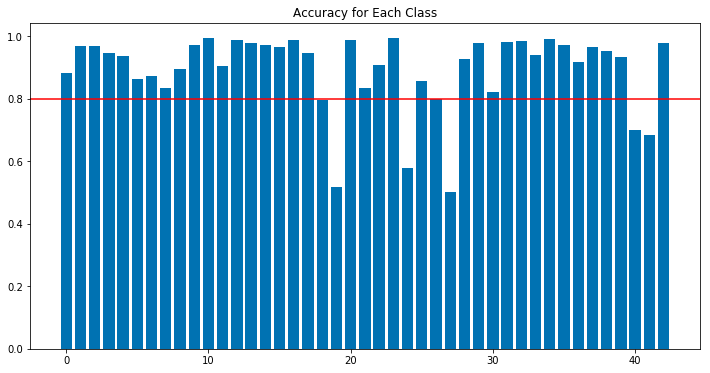

In [41]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(acc_per_class)), acc_per_class, label='Training Accuracy')
plt.title('Accuracy for Each Class')
plt.axhline(0.8, color = 'r')
plt.show()

Delete the endpoint.

In [42]:
predictor.delete_endpoint()